## Library

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
import time
import tempfile  # 추가
import s3fs
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime, timedelta
from scipy.stats import shapiro, spearmanr, kruskal
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')

## Load Data

In [2]:
def load_data(s3_bucket: str, start_year=None, prefix='data/weather/raw'):
    fs = s3fs.S3FileSystem()
    now = datetime.now()
    end_year = now.year
    end_month = now.month

    # 시작 연도 설정
    if start_year is None:
        start_year = (now - timedelta(days=365 * 3)).year

    # S3 경로 목록 생성
    months_reduced = [
        f"s3://{s3_bucket}/{prefix}/year={year}/month={str(month).zfill(2)}"
        for year in range(start_year, end_year + 1)
        for month in range(1, 13)
        if not (year == end_year and month > end_month)
    ]

    all_files = []
    for month_path in months_reduced:
        try:
            day_folders = fs.ls(month_path)
            for day_folder in day_folders:
                files = fs.glob(f"{day_folder}/*.parquet")
                all_files.extend(files)
        except FileNotFoundError:
            continue

    # Parquet 파일 로딩
    df_list = [pd.read_parquet(file, filesystem=fs) for file in all_files]
    df = pd.concat(df_list, ignore_index=True)

    # 데이터 타입 보정
    for col in ['year', 'month', 'day', 'hour']:
        if df[col].dtype == 'object' or df[col].dtype.name == 'category':
            df[col] = df[col].astype(int)

    return df.sort_values(by=['year', 'month', 'day', 'hour'])

In [3]:
s3_bucket = 'mlops-prj'
df = load_data(s3_bucket=s3_bucket, start_year=2020)
df

,ObservationTime,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,GustTime,LocalPressure,SeaLevelPressure,PressureTrend,...,SoilTemperature30cm,SeaCondition,WaveHeight,MaxWindForce,PrecipitationData,ObservationType,hour,year,month,day
0,2020-01-01 00:00:00,108,0,0.0,-9,-9.0,-9,1022.6,1033.8,7,...,3.2,-9,-9.0,-9,4,1,0,2020,1,1
1,2020-01-01 01:00:00,108,5,1.7,-9,-9.0,-9,1021.8,1033.0,-9,...,3.2,-9,-9.0,-9,4,1,1,2020,1,1
2,2020-01-01 02:00:00,108,0,0.1,-9,-9.0,-9,1021.6,1032.8,-9,...,3.1,-9,-9.0,-9,4,1,2,2020,1,1
3,2020-01-01 03:00:00,108,0,0.0,-9,-9.0,-9,1021.5,1032.7,7,...,3.1,-9,-9.0,-9,4,1,3,2020,1,1
4,2020-01-01 04:00:00,108,0,0.0,-9,-9.0,-9,1021.6,1032.8,-9,...,3.0,-9,-9.0,-9,4,1,4,2020,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47660,2025-06-10 07:00:00,108,9,0.8,-9,-9.0,-9,994.0,1003.8,-9,...,22.1,-9,-9.0,-9,3,2,7,2025,6,10
47661,2025-06-10 08:00:00,108,25,2.7,-9,-9.0,-9,994.5,1004.3,-9,...,22.0,-9,-9.0,-9,3,2,8,2025,6,10
47662,2025-06-10 09:00:00,108,27,3.1,-9,-9.0,-9,995.0,1004.8,3,...,21.8,-9,-9.0,-9,3,2,9,2025,6,10
47663,2025-06-10 10:00:00,108,27,3.6,-9,-9.0,-9,995.1,1004.9,-9,...,21.7,-9,-9.0,-9,3,2,10,2025,6,10


In [6]:
df.tail(10)[['ObservationTime']]

,ObservationTime
47655,2025-06-10 02:00:00
47656,2025-06-10 03:00:00
47657,2025-06-10 04:00:00
47658,2025-06-10 05:00:00
47659,2025-06-10 06:00:00
47660,2025-06-10 07:00:00
47661,2025-06-10 08:00:00
47662,2025-06-10 09:00:00
47663,2025-06-10 10:00:00
47664,2025-06-10 11:00:00


In [7]:
df['ObservationTime'] = pd.to_datetime(df['ObservationTime'])
df['gap_hr'] = df['ObservationTime'].diff().dt.total_seconds() / 3600
df[df['gap_hr'] > 1][['ObservationTime', 'gap_hr']]

,ObservationTime,gap_hr
34540,2023-12-10 08:00:00,5.0
34551,2023-12-11 08:00:00,14.0
36731,2024-03-11 11:00:00,8.0
36740,2024-03-12 07:00:00,12.0


In [4]:
df.to_csv("../data/2020-2025.csv", index=False)
df = pd.read_csv("../data/2020-2025.csv")
df

,ObservationTime,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,GustTime,LocalPressure,SeaLevelPressure,PressureTrend,...,SoilTemperature30cm,SeaCondition,WaveHeight,MaxWindForce,PrecipitationData,ObservationType,hour,year,month,day
0,2021-01-01 00:00:00,108,25,1.8,-9,-9.0,-9,1016.4,1027.7,2,...,1.6,-9,-9.0,-9,3,-9,0,2021,1,1
1,2021-01-01 01:00:00,108,27,2.4,-9,-9.0,-9,1016.4,1027.7,-9,...,1.6,-9,-9.0,-9,3,-9,1,2021,1,1
2,2021-01-01 02:00:00,108,27,1.6,-9,-9.0,-9,1016.2,1027.5,-9,...,1.6,-9,-9.0,-9,3,-9,2,2021,1,1
3,2021-01-01 03:00:00,108,25,1.1,-9,-9.0,-9,1016.8,1028.1,3,...,1.6,-9,-9.0,-9,3,-9,3,2021,1,1
4,2021-01-01 04:00:00,108,0,0.3,-9,-9.0,-9,1016.2,1027.5,-9,...,1.5,-9,-9.0,-9,3,-9,4,2021,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38817,2025-06-07 20:00:00,108,20,3.3,-9,-9.0,-9,997.1,1006.9,-9,...,21.4,-9,-9.0,-9,3,-9,20,2025,6,7
38818,2025-06-07 21:00:00,108,25,2.5,-9,-9.0,-9,997.4,1007.2,2,...,21.5,-9,-9.0,-9,3,2,21,2025,6,7
38819,2025-06-07 22:00:00,108,27,2.7,-9,-9.0,-9,998.0,1007.8,-9,...,21.6,-9,-9.0,-9,4,1,22,2025,6,7
38820,2025-06-07 23:00:00,108,25,2.0,-9,-9.0,-9,998.0,1007.8,-9,...,21.7,-9,-9.0,-9,4,1,23,2025,6,7


## Data Preprocessing

- Data Type Check
- Missing Value Check

In [5]:
df.describe()

,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,GustTime,LocalPressure,SeaLevelPressure,PressureTrend,PressureChange,...,SoilTemperature30cm,SeaCondition,WaveHeight,MaxWindForce,PrecipitationData,ObservationType,hour,year,month,day
count,38822.0,38822.000000,38822.000000,38822.000000,38822.000000,38822.000000,38822.000000,38822.000000,38822.000000,38822.000000,...,38822.000000,38822.0,38822.0,38822.0,38822.000000,38822.000000,38822.000000,38822.000000,38822.000000,38822.000000
mean,108.0,18.134254,2.327008,-7.269512,-7.839112,68.279326,1005.782093,1016.027915,-4.617176,-6.000046,...,13.931029,-9.0,-9.0,-9.0,3.101386,-0.827958,11.502447,2022.744269,6.192262,15.672995
std,0.0,10.696044,1.188165,7.348965,4.744971,341.241904,8.060582,8.472756,6.377979,4.299745,...,9.646950,0.0,0.0,0.0,0.399665,4.555070,6.921101,1.295948,3.457533,8.814015
min,108.0,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,981.400000,990.900000,-9.000000,-9.000000,...,-99.000000,-9.0,-9.0,-9.0,1.000000,-9.000000,0.000000,2021.000000,1.000000,1.000000
25%,108.0,7.000000,1.500000,-9.000000,-9.000000,-9.000000,999.400000,1009.300000,-9.000000,-9.000000,...,4.700000,-9.0,-9.0,-9.0,3.000000,1.000000,6.000000,2022.000000,3.000000,8.000000
50%,108.0,23.000000,2.200000,-9.000000,-9.000000,-9.000000,1005.900000,1016.100000,-9.000000,-9.000000,...,14.800000,-9.0,-9.0,-9.0,3.000000,2.000000,12.000000,2023.000000,6.000000,16.000000
75%,108.0,27.000000,3.000000,-9.000000,-9.000000,-9.000000,1012.100000,1022.700000,2.000000,-0.800000,...,23.000000,-9.0,-9.0,-9.0,3.000000,2.000000,17.000000,2024.000000,9.000000,23.000000
max,108.0,36.000000,8.800000,36.000000,24.000000,2354.000000,1027.400000,1038.900000,8.000000,5.500000,...,30.600000,-9.0,-9.0,-9.0,4.000000,2.000000,23.000000,2025.000000,12.000000,31.000000


### Data Type Check

In [6]:
# Data type check
def check_dtype(df, return_data=False):
    object_df = df.select_dtypes(include=['object', 'category'])
    num_df = df.select_dtypes(include=['number'])

    print(f"Object Data Type: {object_df.shape[1]}")
    print(f"Number Data Type: {num_df.shape[1]}")

    if return_data: # 데이터 프레임 할당
        return object_df, num_df

In [7]:
str_df, num_df = check_dtype(df, return_data=True)

Object Data Type: 3
Number Data Type: 47


In [8]:
str_df

,ObservationTime,WeatherCode,CloudType
0,2021-01-01 00:00:00,-,-
1,2021-01-01 01:00:00,-,-
2,2021-01-01 02:00:00,-,-
3,2021-01-01 03:00:00,-,-
4,2021-01-01 04:00:00,-,-
...,...,...,...
38817,2025-06-07 20:00:00,-,-
38818,2025-06-07 21:00:00,-,Sc
38819,2025-06-07 22:00:00,1901,Sc
38820,2025-06-07 23:00:00,1901,Sc


In [9]:
num_df.columns

Index(['StationID', 'WindDirection', 'WindSpeed', 'GustDirection', 'GustSpeed',
       'GustTime', 'LocalPressure', 'SeaLevelPressure', 'PressureTrend',
       'PressureChange', 'Temperature', 'DewPointTemperature',
       'RelativeHumidity', 'VaporPressure', 'HourlyRainfall', 'DailyRainfall',
       'CumulativeRainfall', 'RainfallIntensity', 'SnowDepth3Hr',
       'DailySnowDepth', 'TotalSnowDepth', 'CurrentWeatherCode',
       'PastWeatherCode', 'TotalCloudCover', 'MidLowCloudCover',
       'LowestCloudHeight', 'UpperCloudType', 'MidCloudType', 'LowCloudType',
       'Visibility', 'SunshineDuration', 'SolarRadiation', 'GroundCondition',
       'GroundTemperature', 'SoilTemperature5cm', 'SoilTemperature10cm',
       'SoilTemperature20cm', 'SoilTemperature30cm', 'SeaCondition',
       'WaveHeight', 'MaxWindForce', 'PrecipitationData', 'ObservationType',
       'hour', 'year', 'month', 'day'],
      dtype='object')

In [10]:
# StationID 는 지점번호 를 의미 그래서 문자열로 변경
df['StationID'] = df['StationID'].astype(str)
df['year'] = df['year'].astype(int)
str_df, num_df = check_dtype(df, return_data=True) # 재할당

Object Data Type: 4
Number Data Type: 46


In [11]:
str_df.head()

,ObservationTime,StationID,WeatherCode,CloudType
0,2021-01-01 00:00:00,108,-,-
1,2021-01-01 01:00:00,108,-,-
2,2021-01-01 02:00:00,108,-,-
3,2021-01-01 03:00:00,108,-,-
4,2021-01-01 04:00:00,108,-,-


### Missing Value Check

In [12]:
df.isnull().sum().sum()

0

In [13]:
# -표시 확인
str_df.isin(['-']).sum()

ObservationTime        0
StationID              0
WeatherCode        29030
CloudType          17174
dtype: int64

In [14]:
cols_to_replace = ['CloudType', 'WeatherCode']
df[cols_to_replace] = df[cols_to_replace].replace('-', 'Other')
df.isin(['-']).sum().sum()

0

## EDA

- Normality Test
- Outlier

In [15]:
# 정규성 검토
def normality_test(df):
    df = df.select_dtypes(include=['number'])
    test_col = df.columns

    satisfied_cols = [] # 정규성 만족 컬럼
    unsatisfied_cols = [] # 정규성 불만족 컬럼

    for col in test_col:
        data = df[col]
        stat, p = shapiro(data)
        if p > 0.05:
            satisfied_cols.append(col)
        else:
            unsatisfied_cols.append(col)

    print(f"정규성 만족 컬럼 수: {len(satisfied_cols)}")
    print(f"정규성 불만족 컬럼 수: {len(unsatisfied_cols)}")
    return satisfied_cols, unsatisfied_cols

In [ ]:
yes_norm, no_norm = normality_test(df)
print(f"\n정규성 만족 컬럼: {yes_norm}")

정규성 만족 컬럼 수: 4
정규성 불만족 컬럼 수: 42

정규성 만족 컬럼: ['GroundCondition', 'SeaCondition', 'WaveHeight', 'MaxWindForce']


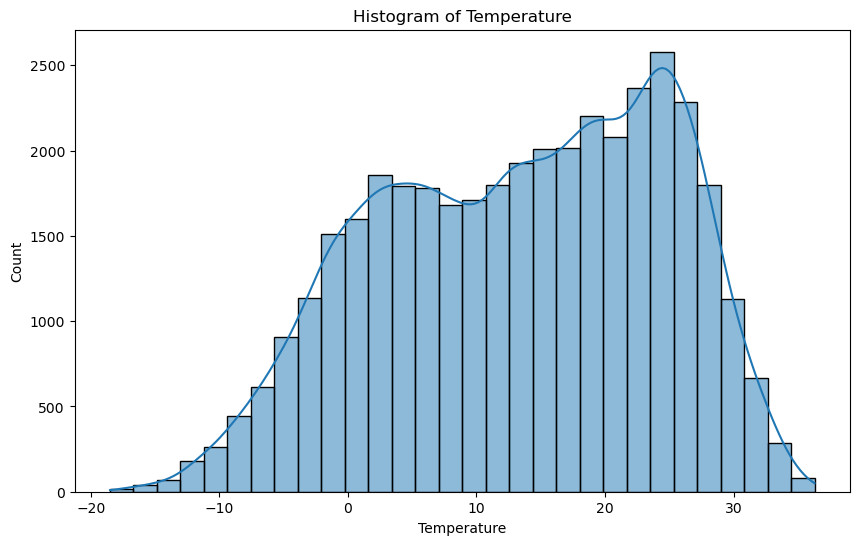

count    38822.000000
mean        13.447978
std         11.020583
min        -18.500000
25%          4.500000
50%         14.400000
75%         22.900000
max         36.300000
Name: Temperature, dtype: float64

In [17]:
# target 변수 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(df['Temperature'], bins=30, kde=True)
plt.title('Histogram of Temperature')
plt.show()

df['Temperature'].describe()

### Outlier

In [18]:
# IQR기반 이상치
def outlier_iqr(df, threshold=1.5):
    df = df.select_dtypes(include=['number']).copy()
    outlier_summary = []

    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - threshold * iqr
        upper = q3 + threshold * iqr

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        ratio = round(len(outliers) / len(df) * 100, 3)

        outlier_summary.append({
            'Column': col,
            'Outlier Count': len(outliers),
            'Outlier Ratio (%)': ratio})

    return pd.DataFrame(outlier_summary).sort_values(by='Outlier Ratio (%)', ascending=False).reset_index(drop=True)

In [19]:
outiler_df = outlier_iqr(df)
outiler_df = outiler_df[outiler_df['Outlier Ratio (%)'] > 0]
outiler_df

,Column,Outlier Count,Outlier Ratio (%)
0,Visibility,9263,23.860
1,PastWeatherCode,9169,23.618
2,ObservationType,9147,23.561
3,CurrentWeatherCode,8485,21.856
4,PrecipitationData,5268,13.570
5,HourlyRainfall,4279,11.022
6,GustDirection,2209,5.690
7,GustSpeed,2209,5.690
8,GustTime,2209,5.690
9,LowestCloudHeight,1868,4.812


In [20]:
# 도메인 기반 컬럼 제외
outiler_cols = outiler_df['Column'].tolist()
remove_cols = ['PastWeatherCode', 'ObservationType', 'PrecipitationData', 'CurrentWeatherCode', 'GustTime']
outlier_cols = [col for col in outiler_cols if col not in remove_cols]

outlier_iqr(df[outlier_cols]) # 재확인

,Column,Outlier Count,Outlier Ratio (%)
0,Visibility,9263,23.860
1,HourlyRainfall,4279,11.022
2,GustDirection,2209,5.690
3,GustSpeed,2209,5.690
4,LowestCloudHeight,1868,4.812
5,TotalSnowDepth,1858,4.786
6,CumulativeRainfall,1542,3.972
7,DailyRainfall,1542,3.972
8,WindSpeed,736,1.896
9,DailySnowDepth,714,1.839


In [21]:
df[outlier_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Visibility,38822.0,1937.752718,898.160382,23.0,1494.0,2000.0,2000.0,5000.0
HourlyRainfall,38822.0,-7.849534,3.475091,-9.0,-9.0,-9.0,-9.0,64.7
GustDirection,38822.0,-7.269512,7.348965,-9.0,-9.0,-9.0,-9.0,36.0
GustSpeed,38822.0,-7.839112,4.744971,-9.0,-9.0,-9.0,-9.0,24.0
LowestCloudHeight,38822.0,3.465535,15.593251,-9.0,-9.0,3.0,10.0,77.0
TotalSnowDepth,38822.0,-8.456741,2.535283,-9.0,-9.0,-9.0,-9.0,28.6
CumulativeRainfall,38822.0,-4.465177,10.591552,-9.0,-9.0,-9.0,0.0,176.2
DailyRainfall,38822.0,-4.465177,10.591552,-9.0,-9.0,-9.0,0.0,176.2
WindSpeed,38822.0,2.327008,1.188165,-9.0,1.5,2.2,3.0,8.8
DailySnowDepth,38822.0,-8.792862,1.571656,-9.0,-9.0,-9.0,-9.0,19.3


In [22]:
# 음수값 확인
negative_cols = df.select_dtypes(include=['number']).columns[df.select_dtypes(include=['number']).lt(0).any()]
negative_cols

Index(['WindDirection', 'WindSpeed', 'GustDirection', 'GustSpeed', 'GustTime',
       'PressureTrend', 'PressureChange', 'Temperature', 'DewPointTemperature',
       'HourlyRainfall', 'DailyRainfall', 'CumulativeRainfall',
       'RainfallIntensity', 'SnowDepth3Hr', 'DailySnowDepth', 'TotalSnowDepth',
       'CurrentWeatherCode', 'PastWeatherCode', 'TotalCloudCover',
       'LowestCloudHeight', 'UpperCloudType', 'MidCloudType', 'LowCloudType',
       'SunshineDuration', 'SolarRadiation', 'GroundCondition',
       'GroundTemperature', 'SoilTemperature5cm', 'SoilTemperature10cm',
       'SoilTemperature20cm', 'SoilTemperature30cm', 'SeaCondition',
       'WaveHeight', 'MaxWindForce', 'ObservationType'],
      dtype='object')

In [23]:
# hist_plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, color1='skyblue', color2='salmon', label1=None, label2=None, title=None):
    plt.figure(figsize=figsize)

    # 개별 데이터 프레임
    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, label=label1 if label1 else ('Group 1' if df2 is not None else None))

    if df2 is not None: # 두 그룹 비교
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, label=label2 if label2 else 'Group 2')
        plt.legend()  # 두 그룹일 때만 범례 표시

    plt.title(title if title else f'{col} Distribution (Histogram + KDE)')
    plt.xlabel(col)
    plt.show()

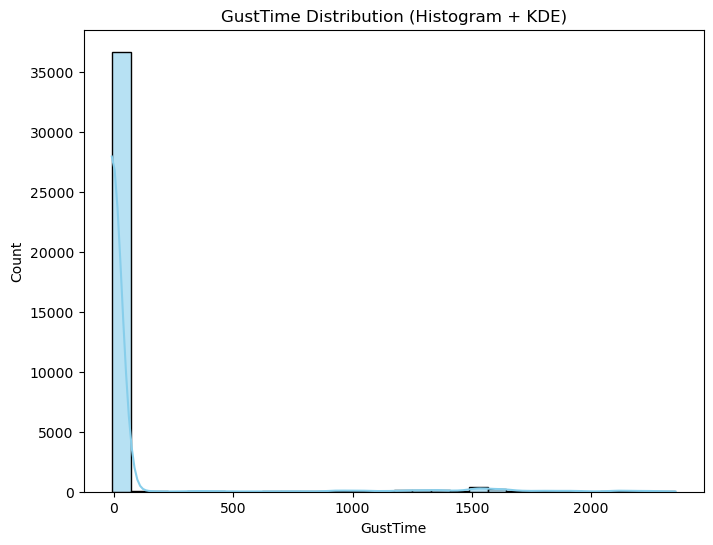

,GustTime
count,38822.000000
mean,68.279326
std,341.241904
min,-9.000000
25%,-9.000000
50%,-9.000000
75%,-9.000000
max,2354.000000


In [24]:
hist_plot(df, 'GustTime')
df[['GustTime']].describe()

In [25]:
impossible_minus_col = [
    'GustSpeed',           # 돌풍 속도: 속도이므로 음수 불가 (0은 바람 없음)
    'HourlyRainfall',      # 시간 강수량: 비의 양이므로 음수 불가 (0은 비 안 옴)
    'DailyRainfall',       # 일 강수량: 비의 양이므로 음수 불가
    'CumulativeRainfall',  # 누적 강수량: 비의 양이므로 음수 불가
    'RainfallIntensity',   # 강수 강도: 강수 세기이므로 음수 불가 (0은 비 안 옴)
    'SnowDepth3Hr',        # 3시간 적설: 눈의 깊이이므로 음수 불가 (0은 눈 안 쌓임)
    'DailySnowDepth',      # 일 적설: 눈의 깊이이므로 음수 불가
    'TotalSnowDepth',      # 총 적설: 눈의 깊이이므로 음수 불가
    'LowestCloudHeight',   # 최저 운고: 고도이므로 음수 불가 (0은 지표면 안개 등)
    'SunshineDuration',    # 일조 시간: 시간 값이므로 음수 불가 (0은 햇빛 없음)
    'SolarRadiation',      # 일사량: 에너지 양이므로 음수 불가 (0은 일사 없음)
    'WaveHeight',          # 파고: 파도의 높이이므로 음수 불가 (0은 파도 없음)
    'MaxWindForce'         # 최대 풍력: 풍력 값이므로 음수 불가
]

for col in impossible_minus_col:
    df[col] = df[col].apply(lambda x: 0 if x < 0 else x)

df[impossible_minus_col].describe().T

,count,mean,std,min,25%,50%,75%,max
GustSpeed,38822.0,0.648782,2.674709,0.0,0.0,0.00,0.00,24.00
HourlyRainfall,38822.0,0.158477,1.262520,0.0,0.0,0.00,0.00,64.70
DailyRainfall,38822.0,1.866722,8.464396,0.0,0.0,0.00,0.00,176.20
CumulativeRainfall,38822.0,1.866722,8.464396,0.0,0.0,0.00,0.00,176.20
RainfallIntensity,38822.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00
SnowDepth3Hr,38822.0,0.004786,0.126381,0.0,0.0,0.00,0.00,9.80
DailySnowDepth,38822.0,0.041613,0.521980,0.0,0.0,0.00,0.00,19.30
TotalSnowDepth,38822.0,0.112524,0.898854,0.0,0.0,0.00,0.00,28.60
LowestCloudHeight,38822.0,7.800938,12.461295,0.0,0.0,3.00,10.00,77.00
SunshineDuration,38822.0,0.260169,0.403490,0.0,0.0,0.00,0.60,1.00


In [26]:
check_outiler = outlier_iqr(df)
check_outiler = check_outiler[check_outiler['Outlier Ratio (%)'] > 0]

outiler_cols = check_outiler['Column'].tolist()
remove_cols = ['PastWeatherCode', 'ObservationType', 'PrecipitationData', 'CurrentWeatherCode', 'GustTime']
outlier_cols = [col for col in outiler_cols if col not in remove_cols]

outlier_iqr(df[outlier_cols]) # 재확인

,Column,Outlier Count,Outlier Ratio (%)
0,Visibility,9263,23.860
1,DailyRainfall,7880,20.298
2,CumulativeRainfall,7880,20.298
3,LowestCloudHeight,3538,9.113
4,SolarRadiation,2698,6.950
5,HourlyRainfall,2384,6.141
6,GustSpeed,2209,5.690
7,GustDirection,2209,5.690
8,TotalSnowDepth,1840,4.740
9,WindSpeed,736,1.896


## Feature Engineering

- Spearman Test
- Kruskal-Wallis Test
- Scaler
- Encoding

### Spearman Test

In [27]:
def spearman_test(df, target_col):
    df_numeric = df.select_dtypes(include=['number'])
    features = []
    correlations = []
    p_values = []

    for col in df_numeric.columns:
        if col != target_col:
            corr, p = spearmanr(df_numeric[target_col], df_numeric[col])
            features.append(col)
            correlations.append(corr)
            p_values.append(p)

    corr_df = pd.DataFrame({
        'Feature': features,
        'Correlation': correlations,
        'P-value': p_values}).sort_values(by='Correlation', ascending=False).reset_index(drop=True)

    return corr_df

# heat_map
def heat_map(df, target_col=None, figsize=(8, 10), threshold=0, cmap='Reds', method='pearson', annot_kws=None, return_data=False):
        df = df.select_dtypes(include=['number'])

        if annot_kws is None:
            annot_kws = {"size": 10}

        if target_col is not None:
            corr_series = df.corr(method=method)[target_col].drop(target_col)
            corr_filtered = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)

            plt.figure(figsize=figsize)
            sns.heatmap(corr_filtered.to_frame(name='Correlation'), annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation with {target_col}', fontsize=14)
            plt.show()

            corr_df = corr_filtered.reset_index()
            corr_df.columns = ['Variable', 'Correlation']

            if return_data:
                return corr_df

        else:
            corr_matrix = df.corr(method=method) # 전체 변수 간 상관계수

            plt.figure(figsize=figsize)
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation Matrix (All Variables)', fontsize=14)
            plt.show()

            if return_data:
                return corr_matrix

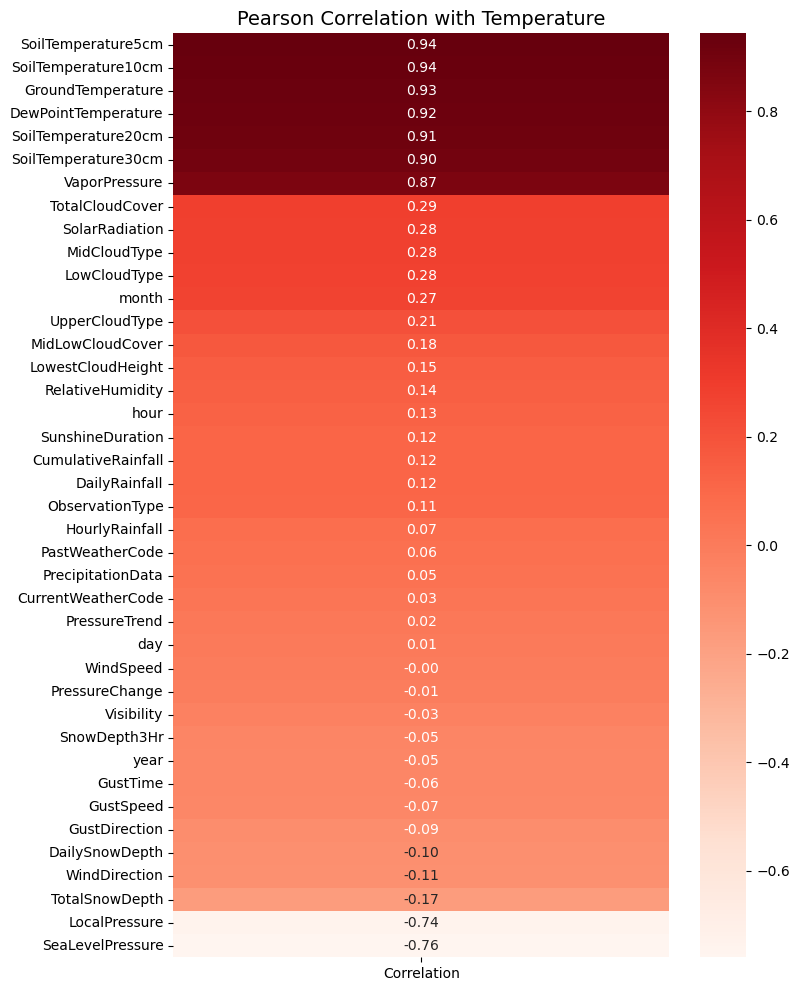

유의미하지 않은 변수의 수: 3
유의미한 변수의 수: 37


,Feature,Correlation,P-value
0,day,0.009573,0.059272
1,PastWeatherCode,0.009500,0.061238
2,CurrentWeatherCode,-0.005696,0.261734


In [28]:
heat_map(df, target_col='Temperature', figsize=(8, 12))
df_spearman = spearman_test(df, 'Temperature')

p_value_05 = df_spearman[df_spearman['P-value'] >= 0.05].reset_index(drop=True)
p_value_over_05 = df_spearman[df_spearman['P-value'] < 0.05].reset_index(drop=True)

print(f'유의미하지 않은 변수의 수: {len(p_value_05)}')
print(f'유의미한 변수의 수: {len(p_value_over_05)}')

p_value_05

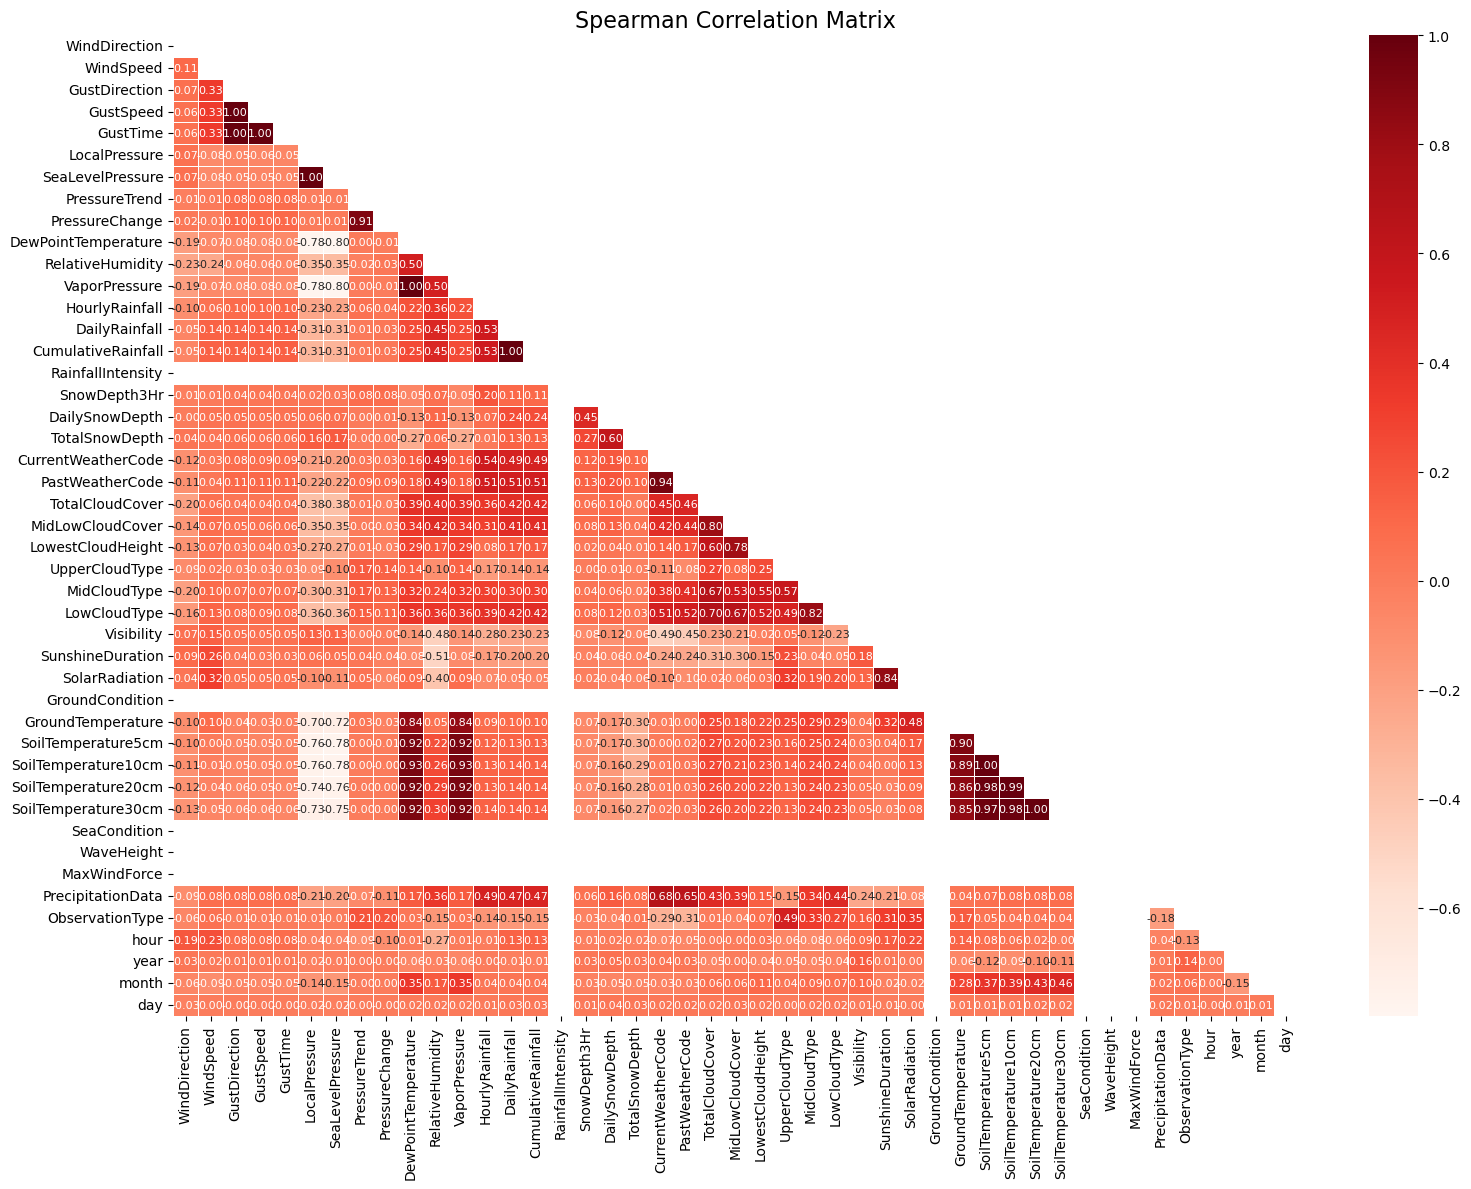

In [29]:
corr = df.select_dtypes(include=['number']).drop(columns=['Temperature']).corr(method='spearman')

plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Reds', linewidths=0.5, mask=np.triu(corr), annot_kws={'size': 8})
plt.title("Spearman Correlation Matrix", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
def remove_high_corr_target(df, target_col, threshold=0.95, method='spearman'):
    feats = df.select_dtypes(include=[np.number]).columns.drop(target_col)
    corr_feats = df[feats].corr(method=method).abs()
    corr_target = df[feats].corrwith(df[target_col], method=method).abs()

    to_drop = set()
    for i, f1 in enumerate(feats):
        for f2 in feats[i+1:]:
            # 0.95 초과인 경우
            if corr_feats.loc[f1, f2] > threshold:
                if corr_target[f1] >= corr_target[f2]:
                    to_drop.add(f2)
                else:
                    to_drop.add(f1)
    return list(to_drop)

In [31]:
corr_drop_cols = remove_high_corr_target(df, target_col='Temperature', threshold=0.95, method='spearman')
print("서로 상관계수가 0.95 초과인 피처 수:", len(corr_drop_cols))
print("상관계수 0.95 초과인 피처:", corr_drop_cols)

서로 상관계수가 0.95 초과인 피처 수: 8
상관계수 0.95 초과인 피처: ['SoilTemperature10cm', 'GustTime', 'LocalPressure', 'DewPointTemperature', 'GustSpeed', 'SoilTemperature20cm', 'SoilTemperature30cm', 'CumulativeRainfall']


In [ ]:
# 유의미하지 않은 변수 제거
p_value_05_cols = p_value_05['Feature'].tolist()
drop_cols = p_value_05_cols + ['GustTime']
drop_cols.remove('day')

df = df.drop(columns=drop_cols)
df

,ObservationTime,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,SeaLevelPressure,PressureTrend,PressureChange,...,SoilTemperature30cm,SeaCondition,WaveHeight,MaxWindForce,PrecipitationData,ObservationType,hour,year,month,day
0,2021-01-01 00:00:00,108,25,1.8,-9,0.0,1016.4,1027.7,2,1.2,...,1.6,-9,0,0,3,-9,0,2021,1,1
1,2021-01-01 01:00:00,108,27,2.4,-9,0.0,1016.4,1027.7,-9,-9.0,...,1.6,-9,0,0,3,-9,1,2021,1,1
2,2021-01-01 02:00:00,108,27,1.6,-9,0.0,1016.2,1027.5,-9,-9.0,...,1.6,-9,0,0,3,-9,2,2021,1,1
3,2021-01-01 03:00:00,108,25,1.1,-9,0.0,1016.8,1028.1,3,0.4,...,1.6,-9,0,0,3,-9,3,2021,1,1
4,2021-01-01 04:00:00,108,0,0.3,-9,0.0,1016.2,1027.5,-9,-9.0,...,1.5,-9,0,0,3,-9,4,2021,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38817,2025-06-07 20:00:00,108,20,3.3,-9,0.0,997.1,1006.9,-9,-9.0,...,21.4,-9,0,0,3,-9,20,2025,6,7
38818,2025-06-07 21:00:00,108,25,2.5,-9,0.0,997.4,1007.2,2,1.1,...,21.5,-9,0,0,3,2,21,2025,6,7
38819,2025-06-07 22:00:00,108,27,2.7,-9,0.0,998.0,1007.8,-9,-9.0,...,21.6,-9,0,0,4,1,22,2025,6,7
38820,2025-06-07 23:00:00,108,25,2.0,-9,0.0,998.0,1007.8,-9,-9.0,...,21.7,-9,0,0,4,1,23,2025,6,7


### Derived Variable

In [34]:
def add_feature(df):
        # season
        df['season'] = df['month'].apply(lambda x:
            'Spring' if 3 <= x <= 5 else
            'Summer' if 6 <= x <= 8 else
            'Fall' if 9 <= x <= 11 else 'Winter')

        # time_segment
        df['time_segment'] = df['hour'].apply(lambda x:
            'Dawn' if 0 <= x < 6 else
            'Morning' if 6 <= x < 12 else
            'Afternoon' if 12 <= x < 18 else
            'Evening' if 18 <= x < 22 else
            'Night')

        # 전날 같은 시각 온도 변화량
        df['prev_day_temp_diff'] = df['Temperature'].diff(24)
        df['prev_day_temp_diff'] = df['prev_day_temp_diff'].fillna(method='bfill')  # 0보다 자연스러움

        # 태양복사량 × 시각 (일사 영향)
        df['temp_solar_effect'] = df['SolarRadiation'] * df['hour'].apply(lambda h: np.sin((np.pi / 24) * h))

        # 지온 - 지표온도 차이
        df['temp_soil_gap'] = df['SoilTemperature5cm'] - df['GroundTemperature']

        # 증기압 대비 습도 비율
        df['vapor_humidity_ratio'] = df['VaporPressure'] / (df['RelativeHumidity'] + 1e-3)

        # 해면기압 - 지역기압 차이
        df['pressure_diff'] = df['SeaLevelPressure'] - df['LocalPressure']

        # Day (0=Monday ~ 6=Sunday)
        df['day_of_week'] = pd.to_datetime(df[['year', 'month', 'day']]).dt.dayofweek

        # Hour (0-23)
        max_hour = 23
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / (max_hour + 1))
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / (max_hour + 1))

        # Month (1-12)
        max_month = 12
        df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / max_month)
        df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / max_month)

        # Day (1-31)
        max_day = 31
        df['day_sin'] = np.sin(2 * np.pi * (df['day'] - 1) / max_day)
        df['day_cos'] = np.cos(2 * np.pi * (df['day'] - 1) / max_day)

        # Day-Week
        df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
        return df

df = add_feature(df)
df.head()

,ObservationTime,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,SeaLevelPressure,PressureTrend,PressureChange,...,pressure_diff,day_of_week,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,dow_sin,dow_cos
0,2021-01-01 00:00:00,108,25,1.8,-9,0.0,1016.4,1027.7,2,1.2,...,11.3,4,0.000000,1.000000,0.0,1.0,0.0,1.0,-0.433884,-0.900969
1,2021-01-01 01:00:00,108,27,2.4,-9,0.0,1016.4,1027.7,-9,-9.0,...,11.3,4,0.258819,0.965926,0.0,1.0,0.0,1.0,-0.433884,-0.900969
2,2021-01-01 02:00:00,108,27,1.6,-9,0.0,1016.2,1027.5,-9,-9.0,...,11.3,4,0.500000,0.866025,0.0,1.0,0.0,1.0,-0.433884,-0.900969
3,2021-01-01 03:00:00,108,25,1.1,-9,0.0,1016.8,1028.1,3,0.4,...,11.3,4,0.707107,0.707107,0.0,1.0,0.0,1.0,-0.433884,-0.900969
4,2021-01-01 04:00:00,108,0,0.3,-9,0.0,1016.2,1027.5,-9,-9.0,...,11.3,4,0.866025,0.500000,0.0,1.0,0.0,1.0,-0.433884,-0.900969


### Kruskal-Wallis Test

In [35]:
def kruskal_test(df, target_col, min_group_size=5):
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    results = []

    for col in cat_cols:
        grouped = df.groupby(col)[target_col]
        valid_groups = [grp.values for _, grp in grouped if grp.size >= min_group_size]
        if len(valid_groups) >= 2:
            stat, p = kruskal(*valid_groups)
            results.append({'feature': col, 'H-statistic': stat, 'p-value': p})

    return pd.DataFrame(results).sort_values('p-value').reset_index(drop=True)

In [ ]:
kruskal_df = kruskal_test(df, 'Temperature')
kruskal_df[kruskal_df['p-value'] < 0.05]

,feature,H-statistic,p-value
0,WeatherCode,2911.522955,0.0
1,CloudType,4968.876226,0.0
2,season,27160.878724,0.0
3,time_segment,1562.933154,0.0


In [37]:
df.columns

Index(['ObservationTime', 'StationID', 'WindDirection', 'WindSpeed',
       'GustDirection', 'GustSpeed', 'LocalPressure', 'SeaLevelPressure',
       'PressureTrend', 'PressureChange', 'Temperature', 'DewPointTemperature',
       'RelativeHumidity', 'VaporPressure', 'HourlyRainfall', 'DailyRainfall',
       'CumulativeRainfall', 'RainfallIntensity', 'SnowDepth3Hr',
       'DailySnowDepth', 'TotalSnowDepth', 'WeatherCode', 'TotalCloudCover',
       'MidLowCloudCover', 'LowestCloudHeight', 'CloudType', 'UpperCloudType',
       'MidCloudType', 'LowCloudType', 'Visibility', 'SunshineDuration',
       'SolarRadiation', 'GroundCondition', 'GroundTemperature',
       'SoilTemperature5cm', 'SoilTemperature10cm', 'SoilTemperature20cm',
       'SoilTemperature30cm', 'SeaCondition', 'WaveHeight', 'MaxWindForce',
       'PrecipitationData', 'ObservationType', 'hour', 'year', 'month', 'day',
       'season', 'time_segment', 'prev_day_temp_diff', 'temp_solar_effect',
       'temp_soil_gap', 'vapor_h

In [39]:
# 날씨 코드 'WeatherCode', 지점번호 'StationID', 관측시간 'ObservationTime' 제거
df = df.drop(columns=['WeatherCode', 'StationID', 'ObservationTime'])

# 컬럼 순서 변경
df = df[['year', 'month', 'day', 'hour', 'Temperature'] + [c for c in df if c not in ['year', 'month', 'day', 'hour', 'Temperature']]]
df

,year,month,day,hour,Temperature,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,...,pressure_diff,day_of_week,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,dow_sin,dow_cos
0,2021,1,1,0,-8.3,25,1.8,-9,0.0,1016.4,...,11.3,4,0.000000,1.000000,0.0,1.000000,0.000000,1.000000,-0.433884,-0.900969
1,2021,1,1,1,-8.7,27,2.4,-9,0.0,1016.4,...,11.3,4,0.258819,0.965926,0.0,1.000000,0.000000,1.000000,-0.433884,-0.900969
2,2021,1,1,2,-9.1,27,1.6,-9,0.0,1016.2,...,11.3,4,0.500000,0.866025,0.0,1.000000,0.000000,1.000000,-0.433884,-0.900969
3,2021,1,1,3,-9.3,25,1.1,-9,0.0,1016.8,...,11.3,4,0.707107,0.707107,0.0,1.000000,0.000000,1.000000,-0.433884,-0.900969
4,2021,1,1,4,-9.3,0,0.3,-9,0.0,1016.2,...,11.3,4,0.866025,0.500000,0.0,1.000000,0.000000,1.000000,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38817,2025,6,7,20,24.0,20,3.3,-9,0.0,997.1,...,9.8,5,-0.866025,0.500000,0.5,-0.866025,0.937752,0.347305,-0.974928,-0.222521
38818,2025,6,7,21,23.5,25,2.5,-9,0.0,997.4,...,9.8,5,-0.707107,0.707107,0.5,-0.866025,0.937752,0.347305,-0.974928,-0.222521
38819,2025,6,7,22,23.0,27,2.7,-9,0.0,998.0,...,9.8,5,-0.500000,0.866025,0.5,-0.866025,0.937752,0.347305,-0.974928,-0.222521
38820,2025,6,7,23,22.3,25,2.0,-9,0.0,998.0,...,9.8,5,-0.258819,0.965926,0.5,-0.866025,0.937752,0.347305,-0.974928,-0.222521


### Split Data

In [ ]:
HORIZON = 168  # 예측하려는 미래 7일/일주일 (168시간)
SEQ_LEN = 336  # 입력 시퀀스: 과거 14일

df = df.sort_values(by=['year', 'month', 'day', 'hour']).reset_index(drop=True)
val_total_len = SEQ_LEN + HORIZON
val_df = df.iloc[-val_total_len:].copy()
train_df = df.iloc[:-val_total_len].copy()
latest_input = df.iloc[-SEQ_LEN:].copy()

print(f"train_df: {train_df.shape}")
print(f"val_df: {val_df.shape}")
print(f"latest_input: {latest_input.shape}")
train_df.head()

train_df: (38318, 60)
val_df: (504, 60)
latest_input: (336, 60)


,year,month,day,hour,Temperature,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,...,pressure_diff,day_of_week,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,dow_sin,dow_cos
0,2021,1,1,0,-8.3,25,1.8,-9,0.0,1016.4,...,11.3,4,0.000000,1.000000,0.0,1.0,0.0,1.0,-0.433884,-0.900969
1,2021,1,1,1,-8.7,27,2.4,-9,0.0,1016.4,...,11.3,4,0.258819,0.965926,0.0,1.0,0.0,1.0,-0.433884,-0.900969
2,2021,1,1,2,-9.1,27,1.6,-9,0.0,1016.2,...,11.3,4,0.500000,0.866025,0.0,1.0,0.0,1.0,-0.433884,-0.900969
3,2021,1,1,3,-9.3,25,1.1,-9,0.0,1016.8,...,11.3,4,0.707107,0.707107,0.0,1.0,0.0,1.0,-0.433884,-0.900969
4,2021,1,1,4,-9.3,0,0.3,-9,0.0,1016.2,...,11.3,4,0.866025,0.500000,0.0,1.0,0.0,1.0,-0.433884,-0.900969


### Scaler

In [ ]:
train = train_df.copy()
val   = val_df.copy()
latest= latest_input.copy()

exclude_cols = ['Temperature', 'year', 'month', 'day', 'hour', 'month_sin', 'month_cos', 
                        'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'day_of_week']
num_cols = [col for col in train.select_dtypes(include=['number']).columns if col not in exclude_cols]

scaler = RobustScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
val[num_cols] = scaler.transform(val[num_cols])
latest[num_cols] = scaler.transform(latest[num_cols])

train

,year,month,day,hour,Temperature,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,...,pressure_diff,day_of_week,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,dow_sin,dow_cos
0,2021,1,1,0,-8.3,0.10,-0.266667,0.0,0.0,0.811024,...,1.222222,4,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,-0.433884,-0.900969
1,2021,1,1,1,-8.7,0.20,0.133333,0.0,0.0,0.811024,...,1.222222,4,0.258819,0.965926,0.000000,1.0,0.000000,1.000000,-0.433884,-0.900969
2,2021,1,1,2,-9.1,0.20,-0.400000,0.0,0.0,0.795276,...,1.222222,4,0.500000,0.866025,0.000000,1.0,0.000000,1.000000,-0.433884,-0.900969
3,2021,1,1,3,-9.3,0.10,-0.733333,0.0,0.0,0.842520,...,1.222222,4,0.707107,0.707107,0.000000,1.0,0.000000,1.000000,-0.433884,-0.900969
4,2021,1,1,4,-9.3,-1.15,-1.266667,0.0,0.0,0.795276,...,1.222222,4,0.866025,0.500000,0.000000,1.0,0.000000,1.000000,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38313,2025,5,17,20,15.7,0.00,0.866667,0.0,0.0,-0.850394,...,-0.111111,5,-0.866025,0.500000,0.866025,-0.5,-0.101168,-0.994869,-0.974928,-0.222521
38314,2025,5,17,21,15.4,0.20,-0.066667,25.0,11.0,-0.779528,...,-0.111111,5,-0.707107,0.707107,0.866025,-0.5,-0.101168,-0.994869,-0.974928,-0.222521
38315,2025,5,17,22,15.0,0.10,0.666667,0.0,0.0,-0.708661,...,-0.111111,5,-0.500000,0.866025,0.866025,-0.5,-0.101168,-0.994869,-0.974928,-0.222521
38316,2025,5,17,23,14.9,0.10,0.000000,0.0,0.0,-0.685039,...,-0.111111,5,-0.258819,0.965926,0.866025,-0.5,-0.101168,-0.994869,-0.974928,-0.222521


### Encoding

In [42]:
str_df, num_df = check_dtype(df ,return_data=True)

for col in str_df.columns:
    print(f"{col}의 유니크 수: {str_df[col].nunique()}")

Object Data Type: 3
Number Data Type: 57
CloudType의 유니크 수: 59
season의 유니크 수: 4
time_segment의 유니크 수: 5


In [43]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from packaging import version
import sklearn

# 인코더 저장용
label_encoders = {}
onehot_encoders = {}

# 문자열(범주형) 컬럼 추출
str_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()
label_cols = []
onehot_cols = []

# 라벨 vs 원핫 기준 분리
for col in str_cols:
    if train[col].nunique() <= 10:
        onehot_cols.append(col)
    else:
        label_cols.append(col)

# Label Encoding
for col in label_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = val[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    latest[col] = latest[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    label_encoders[col] = le

# One-Hot Encoding
for col in onehot_cols:
    if version.parse(sklearn.__version__) >= version.parse("1.2.0"):
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    else:
        ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

    # 학습
    ohe.fit(train[[col]])
    ohe_cols = ohe.get_feature_names_out([col])

    # train
    train_ohe = pd.DataFrame(ohe.transform(train[[col]]), columns=ohe_cols, index=train.index)
    train.drop(columns=[col], inplace=True)
    train = pd.concat([train, train_ohe], axis=1)

    # val
    val_ohe = pd.DataFrame(ohe.transform(val[[col]]), columns=ohe_cols, index=val.index)
    val.drop(columns=[col], inplace=True)
    val = pd.concat([val, val_ohe], axis=1)

    # latest
    latest_ohe = pd.DataFrame(ohe.transform(latest[[col]]), columns=ohe_cols, index=latest.index)
    latest.drop(columns=[col], inplace=True)
    latest = pd.concat([latest, latest_ohe], axis=1)

    onehot_encoders[col] = ohe

# 시계열 보존
latest_time = latest[['year', 'month', 'day', 'hour']].copy()

# 불필요 날짜 컬럼 제거
drop_cols = ['year', 'month', 'day']
train.drop(columns=drop_cols, inplace=True)
val.drop(columns=drop_cols, inplace=True)
latest.drop(columns=drop_cols, inplace=True)

# 컬럼 순서 통일
val = val[train.columns]
latest = latest[train.columns]

print(f"train: {train.shape}")
print(f"val: {val.shape}")
print(f"latest: {latest.shape}")
train

train: (38318, 64)
val: (504, 64)
latest: (336, 64)


,hour,Temperature,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,SeaLevelPressure,PressureTrend,PressureChange,...,dow_cos,season_Fall,season_Spring,season_Summer,season_Winter,time_segment_Afternoon,time_segment_Dawn,time_segment_Evening,time_segment_Morning,time_segment_Night
0,0,-8.3,0.10,-0.266667,0.0,0.0,0.811024,0.850746,1.000000,1.243902,...,-0.900969,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1,-8.7,0.20,0.133333,0.0,0.0,0.811024,0.850746,0.000000,0.000000,...,-0.900969,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2,-9.1,0.20,-0.400000,0.0,0.0,0.795276,0.835821,0.000000,0.000000,...,-0.900969,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,3,-9.3,0.10,-0.733333,0.0,0.0,0.842520,0.880597,1.090909,1.146341,...,-0.900969,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,4,-9.3,-1.15,-1.266667,0.0,0.0,0.795276,0.835821,0.000000,0.000000,...,-0.900969,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38313,20,15.7,0.00,0.866667,0.0,0.0,-0.850394,-0.813433,0.000000,0.000000,...,-0.222521,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
38314,21,15.4,0.20,-0.066667,25.0,11.0,-0.779528,-0.746269,1.000000,1.353659,...,-0.222521,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
38315,22,15.0,0.10,0.666667,0.0,0.0,-0.708661,-0.679104,0.000000,0.000000,...,-0.222521,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38316,23,14.9,0.10,0.000000,0.0,0.0,-0.685039,-0.656716,0.000000,0.000000,...,-0.222521,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [44]:
def check_column_order(X_train, X_val, X_train_name='X_train', X_val_name='X_val'):
    if X_train.columns.tolist() == X_val.columns.tolist():
        print(f"{X_train_name}과 {X_val_name}의 컬럼 및 순서가 모두 일치")
    else:
        print(f"{X_train_name}과 {X_val_name}의 컬럼 또는 순서 불일치")

        train_cols_set = set(X_train.columns)
        val_cols_set = set(X_val.columns)

        only_in_train = list(train_cols_set - val_cols_set)
        only_in_val = list(val_cols_set - train_cols_set)

        if only_in_train or only_in_val:
            print("컬럼 이름 불일치:")
            print(f"{X_train_name}에만 있는 컬럼:", only_in_train)
            print(f"{X_val_name}에만 있는 컬럼:", only_in_val)
        else:
            print("컬럼 이름은 동일하나 순서가 다름\n")

            for i, (col_train, col_val) in enumerate(zip(X_train.columns, X_val.columns)):
                if col_train != col_val:
                    print(f"{i}번째 컬럼 순서 불일치: {X_train_name} = {col_train}, {X_val_name} = {col_val}")

check_column_order(train, val, 'train', 'val')
check_column_order(train, latest, 'train', 'latest')

train과 val의 컬럼 및 순서가 모두 일치
train과 latest의 컬럼 및 순서가 모두 일치


In [45]:
# # 컬럼 순서 통일
# val = val[train.columns]
# latest_input = latest_input[train.columns]
# check_column_order(train, val, 'train', 'val') # 재확인
# check_column_order(train, latest_input, 'train', 'latest_input') # 재확인

## Models

In [47]:
# Dataset 클래스
class TempDataset(Dataset):
    def __init__(self, df, label_col, horizon, seq_len):
        self.seq_len = seq_len
        self.horizon = horizon
        self.X = df.drop(columns=[label_col]).values.astype(np.float32)
        self.y = df[label_col].values.astype(np.float32)
        self.input_len = len(self.X) - seq_len - horizon + 1

    def __len__(self):
        return self.input_len

    def __getitem__(self, idx):
        X_seq = self.X[idx: idx + self.seq_len]
        y_seq = self.y[idx + self.seq_len: idx + self.seq_len + self.horizon]
        return torch.tensor(X_seq), torch.tensor(y_seq)

# LSTM 모델 정의
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # [B, seq_len, H]
        last_out = lstm_out[:, -1, :]  # [B, H]
        output = self.fc(last_out)     # [B, horizon]
        return output

# Trainer 클래스
class LSTMTrainer:
    def __init__(self, model, device, lr=0.001):
        self.model = model.to(device)
        self.device = device
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        self.train_losses = []
        self.val_losses = []

    def train(self, train_loader, val_loader, epochs=20, patience=5):
        best_val_loss = float('inf')
        best_model = None
        wait = 0

        for epoch in range(1, epochs + 1):
            self.model.train()
            train_loss = 0.0
            for X, y in train_loader:
                X, y = X.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                pred = self.model(X)
                loss = self.criterion(pred, y)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)

            # Validation
            self.model.eval()
            val_loss = 0.0
            all_preds, all_labels = [], []
            with torch.no_grad():
                for Xv, yv in val_loader:
                    Xv, yv = Xv.to(self.device), yv.to(self.device)
                    pred = self.model(Xv)
                    loss = self.criterion(pred, yv)
                    val_loss += loss.item()
                    all_preds.extend(pred.cpu().numpy())
                    all_labels.extend(yv.cpu().numpy())
            val_loss /= len(val_loader)
            rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model.state_dict()
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping triggered at epoch {epoch}.")
                    break

        # Best 모델 로드
        if best_model is not None:
            self.model.load_state_dict(best_model)


def predict(model, device, latest_seq, latest_time, horizon=168):
    model.eval()
    with torch.no_grad():
        inp = torch.tensor(latest_seq, dtype=torch.float32).unsqueeze(0).to(device)  # [1, seq_len, input_size]
        output = model(inp)  # [1, horizon]
        preds = output.cpu().numpy().flatten()

    # 예측 시점 생성
    last_row = latest_time.iloc[-1]
    last_time = datetime(
        year=int(last_row["year"]),
        month=int(last_row["month"]),
        day=int(last_row["day"]),
        hour=int(last_row["hour"])
    )
    future_times = [last_time + timedelta(hours=i + 1) for i in range(horizon)]

    df = pd.DataFrame({
        'year': [t.year for t in future_times],
        'month': [t.month for t in future_times],
        'day': [t.day for t in future_times],
        'hour': [t.hour for t in future_times],
        'day_of_week': [t.strftime('%A') for t in future_times],
        'pred_Temperature': np.round(preds, 1)
    })

    return df

In [48]:
# 파라미터 정의
HORIZON = 168  # 예측할 시간 수 (7일)
SEQ_LEN = 336  # 입력 시계열 길이 (2주)
BATCH_SIZE = 32
EPOCHS = 5
LR = 0.001  # 학습률
DROPOUT = 0.4  # 드롭아웃
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더
train_loader = DataLoader(TempDataset(train, 'Temperature', HORIZON, SEQ_LEN), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TempDataset(val, 'Temperature', HORIZON, SEQ_LEN), batch_size=BATCH_SIZE, shuffle=False)

# 모델 초기화 및 학습
model = LSTM_Model(input_size=train.shape[1]-1, hidden_size=128, num_layers=2, output_size=HORIZON, dropout=DROPOUT)
trainer = LSTMTrainer(model, DEVICE, lr=LR)  # ← 여기서 input_size 제거
trainer.train(train_loader, val_loader, epochs=EPOCHS)

# 예측
latest_seq = latest.drop(columns=['Temperature']).values[-SEQ_LEN:].astype(np.float32)
pred_df = predict(trainer.model, DEVICE, latest_seq, latest_time, horizon=HORIZON)
pred_df

[Epoch 1] Train Loss: 57.6324 | Val Loss: 14.9395 | RMSE: 3.8652
[Epoch 2] Train Loss: 16.8307 | Val Loss: 23.2657 | RMSE: 4.8235
[Epoch 3] Train Loss: 12.2394 | Val Loss: 9.5265 | RMSE: 3.0865
[Epoch 4] Train Loss: 7.4144 | Val Loss: 8.2058 | RMSE: 2.8646
[Epoch 5] Train Loss: 5.1668 | Val Loss: 7.4879 | RMSE: 2.7364


,year,month,day,hour,day_of_week,pred_Temperature
0,2025,6,8,16,Sunday,21.500000
1,2025,6,8,17,Sunday,20.900000
2,2025,6,8,18,Sunday,20.600000
3,2025,6,8,19,Sunday,20.299999
4,2025,6,8,20,Sunday,20.000000
...,...,...,...,...,...,...
163,2025,6,15,11,Sunday,26.400000
164,2025,6,15,12,Sunday,25.500000
165,2025,6,15,13,Sunday,24.700001
166,2025,6,15,14,Sunday,24.000000


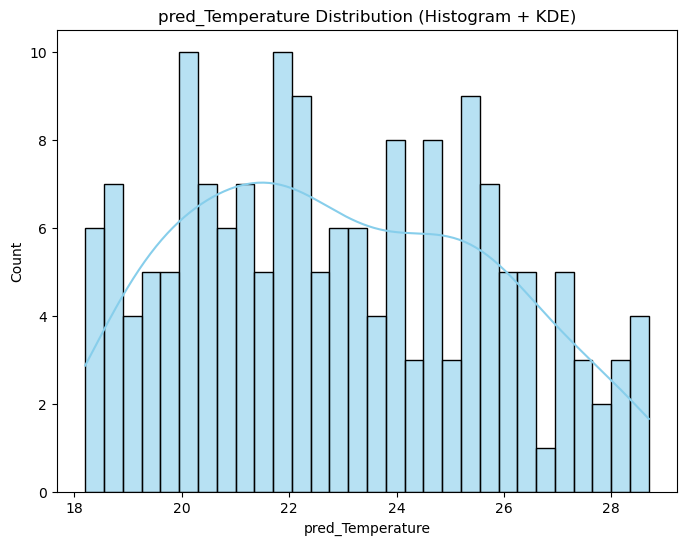

In [ ]:
hist_plot(pred_df, 'pred_Temperature')

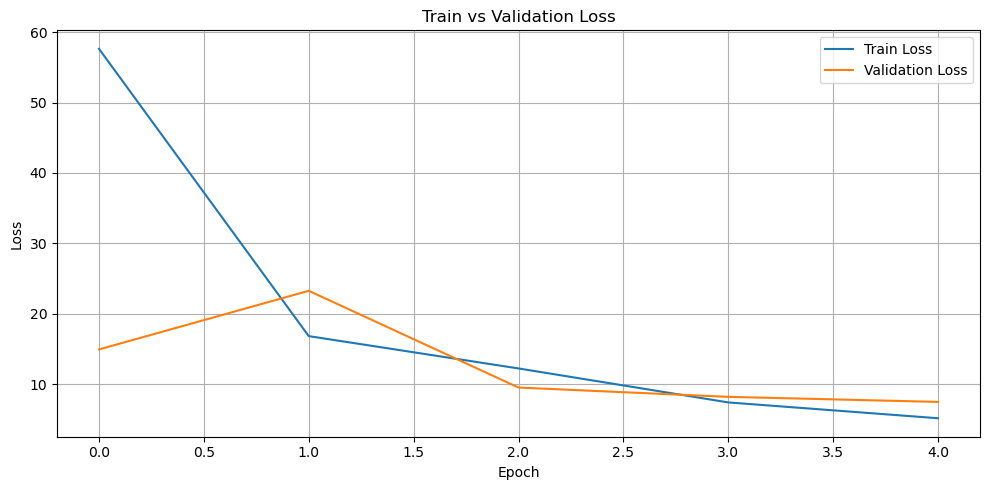

In [ ]:
def plot_losses(trainer):
    plt.figure(figsize=(10, 5))
    plt.plot(trainer.train_losses, label='Train Loss')
    plt.plot(trainer.val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_losses(trainer)

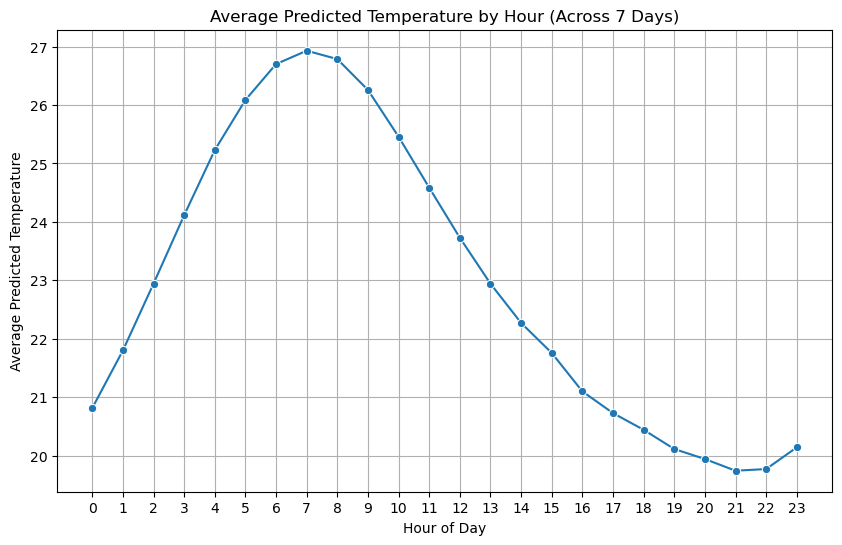

In [51]:
hourly_avg = pred_df.groupby('hour')['pred_Temperature'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_avg, x='hour', y='pred_Temperature', marker='o')
plt.title("Average Predicted Temperature by Hour (Across 7 Days)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Predicted Temperature")
plt.grid(True)
plt.xticks(range(0, 24))  # 0~23시
plt.show()

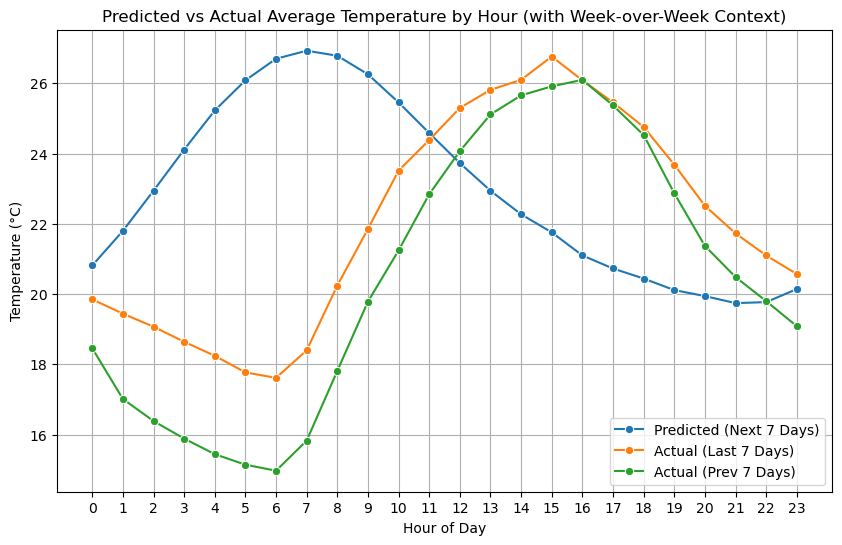

In [54]:
# 모델 예측 (향후 7일)
hourly_pred = pred_df.groupby('hour')['pred_Temperature'].mean().reset_index()
hourly_pred.rename(columns={'pred_Temperature': 'Predicted'}, inplace=True)

# 실제값에서 최근 14일 중 마지막 7일과 그 전 7일 분할
n_pred_rows = len(pred_df)  # 보통 168개 (7일 * 24시간)
latest_recent = latest.iloc[-n_pred_rows:]            # 최신 7일
latest_previous = latest.iloc[-2 * n_pred_rows:-n_pred_rows]  # 이전 7일

# 시간대별 평균 계산
hourly_actual_recent = latest_recent.groupby('hour')['Temperature'].mean().reset_index()
hourly_actual_recent.rename(columns={'Temperature': 'Actual_Recent'}, inplace=True)

hourly_actual_prev = latest_previous.groupby('hour')['Temperature'].mean().reset_index()
hourly_actual_prev.rename(columns={'Temperature': 'Actual_Prev'}, inplace=True)

# 병합
comparison_df = hourly_pred.merge(hourly_actual_recent, on='hour') \
                           .merge(hourly_actual_prev, on='hour')

# 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=comparison_df, x='hour', y='Predicted', marker='o', label='Predicted (Next 7 Days)')
sns.lineplot(data=comparison_df, x='hour', y='Actual_Recent', marker='o', label='Actual (Last 7 Days)')
sns.lineplot(data=comparison_df, x='hour', y='Actual_Prev', marker='o', label='Actual (Prev 7 Days)')
plt.title("Predicted vs Actual Average Temperature by Hour (with Week-over-Week Context)")
plt.xlabel("Hour of Day")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.legend()
plt.show()

In [59]:
latest_input

,year,month,day,hour,Temperature,WindDirection,WindSpeed,GustDirection,GustSpeed,LocalPressure,...,pressure_diff,day_of_week,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,dow_sin,dow_cos
38486,2025,5,25,1,13.6,34,0.9,-9,0.0,1001.3,...,10.2,6,0.258819,0.965926,0.866025,-0.500000,-0.988468,0.151428,-0.781831,0.623490
38487,2025,5,25,2,12.9,36,0.9,-9,0.0,1001.4,...,10.2,6,0.500000,0.866025,0.866025,-0.500000,-0.988468,0.151428,-0.781831,0.623490
38488,2025,5,25,3,12.5,32,1.1,-9,0.0,1002.0,...,10.3,6,0.707107,0.707107,0.866025,-0.500000,-0.988468,0.151428,-0.781831,0.623490
38489,2025,5,25,4,12.1,32,0.9,-9,0.0,1001.9,...,10.3,6,0.866025,0.500000,0.866025,-0.500000,-0.988468,0.151428,-0.781831,0.623490
38490,2025,5,25,5,11.8,29,1.2,-9,0.0,1002.0,...,10.3,6,0.965926,0.258819,0.866025,-0.500000,-0.988468,0.151428,-0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38817,2025,6,7,20,24.0,20,3.3,-9,0.0,997.1,...,9.8,5,-0.866025,0.500000,0.500000,-0.866025,0.937752,0.347305,-0.974928,-0.222521
38818,2025,6,7,21,23.5,25,2.5,-9,0.0,997.4,...,9.8,5,-0.707107,0.707107,0.500000,-0.866025,0.937752,0.347305,-0.974928,-0.222521
38819,2025,6,7,22,23.0,27,2.7,-9,0.0,998.0,...,9.8,5,-0.500000,0.866025,0.500000,-0.866025,0.937752,0.347305,-0.974928,-0.222521
38820,2025,6,7,23,22.3,25,2.0,-9,0.0,998.0,...,9.8,5,-0.258819,0.965926,0.500000,-0.866025,0.937752,0.347305,-0.974928,-0.222521


## Inference Check

In [2]:
# path
train_path = 's3://mlops-prj/data/weather/feature/train/train_2025.06.10_0012.parquet'
val_path = 's3://mlops-prj/data/weather/feature/val/val_2025.06.10_0012.parquet'
latest_path = 's3://mlops-prj/data/weather/feature/latest/latest2025.06.10_0012.parquet'
pred_path = 's3://mlops-prj/data/weather/inference/forecast_20250610_0030.parquet'

s3 = s3fs.S3FileSystem()
train = pd.read_parquet(train_path, filesystem=s3)
val = pd.read_parquet(val_path, filesystem=s3)
latest = pd.read_parquet(latest_path, filesystem=s3)
pred = pd.read_parquet(pred_path, filesystem=s3)

print(f"Train Data: {train.shape}")
print(f"Val Data: {train.shape}")
print(f"Latest Data: {latest.shape}")
print(f"Predict Data: {pred.shape}")

Train Data: (12055, 49)
Val Data: (12055, 49)
Latest Data: (336, 49)
Predict Data: (168, 6)


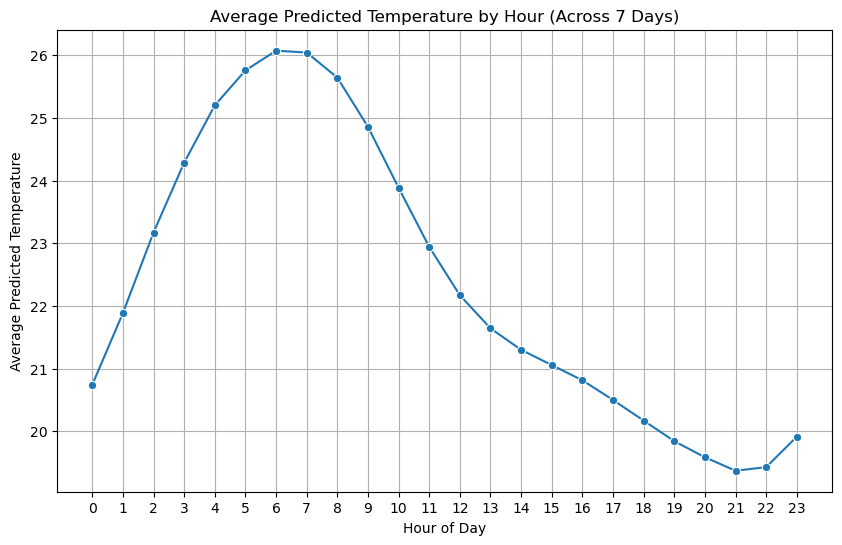

In [3]:
hourly_avg = pred.groupby('hour')['pred_Temperature'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_avg, x='hour', y='pred_Temperature', marker='o')
plt.title("Average Predicted Temperature by Hour (Across 7 Days)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Predicted Temperature")
plt.grid(True)
plt.xticks(range(0, 24))  # 0~23시
plt.show()

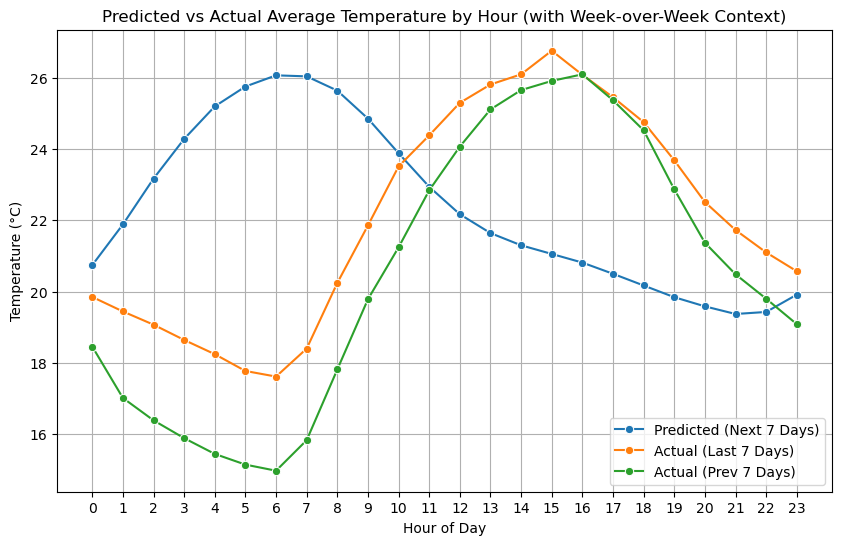

In [4]:
# 모델 예측 (향후 7일)
hourly_pred = pred.groupby('hour')['pred_Temperature'].mean().reset_index()
hourly_pred.rename(columns={'pred_Temperature': 'Predicted'}, inplace=True)

# 실제값에서 최근 14일 중 마지막 7일과 그 전 7일 분할
n_pred_rows = len(pred)  # 보통 168개 (7일 * 24시간)
latest_recent = latest.iloc[-n_pred_rows:]            # 최신 7일
latest_previous = latest.iloc[-2 * n_pred_rows:-n_pred_rows]  # 이전 7일

# 시간대별 평균 계산
hourly_actual_recent = latest_recent.groupby('hour')['Temperature'].mean().reset_index()
hourly_actual_recent.rename(columns={'Temperature': 'Actual_Recent'}, inplace=True)

hourly_actual_prev = latest_previous.groupby('hour')['Temperature'].mean().reset_index()
hourly_actual_prev.rename(columns={'Temperature': 'Actual_Prev'}, inplace=True)

# 병합
comparison_df = hourly_pred.merge(hourly_actual_recent, on='hour') \
                           .merge(hourly_actual_prev, on='hour')

# 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=comparison_df, x='hour', y='Predicted', marker='o', label='Predicted (Next 7 Days)')
sns.lineplot(data=comparison_df, x='hour', y='Actual_Recent', marker='o', label='Actual (Last 7 Days)')
sns.lineplot(data=comparison_df, x='hour', y='Actual_Prev', marker='o', label='Actual (Prev 7 Days)')
plt.title("Predicted vs Actual Average Temperature by Hour (with Week-over-Week Context)")
plt.xlabel("Hour of Day")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.legend()
plt.show()